# Grokking

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/timaeus-research/devinterp/blob/main/examples/grokking.ipynb)

This notebook aims to show how LLC estimation is calibrated in a simple modular addition grokking example, showing a moderately interesting result at the end.

We'll starting off with some standard grokking code, adapted loosely from Nina Panickssery and Dmitry Vaintrob's [modular addition learning coefficient post](https://www.alignmentforum.org/posts/4v3hMuKfsGatLXPgt/investigating-the-learning-coefficient-of-modular-addition) and [github code repo](https://github.com/nrimsky/devinterp). (Thank you for your help!)

In [1]:
%pip install devinterp nbformat
%pip install devinterp[vis]

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import random
from copy import deepcopy
from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm

from devinterp.optim.sgld import SGLD
from devinterp.slt.sampler import estimate_learning_coeff_with_summary
from devinterp.utils import evaluate_ce

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
@dataclass
class ExperimentParams:
    p: int = 100
    l: int = 5
    v = 10
    n_batches: int = 10000
    n_save_model_checkpoints: int = 100
    print_times: int = 100
    lr: float = 3e-3
    batch_size: int = 128
    hidden_size: int = 48
    embed_dim: int = 12
    train_frac: float = 0.4
    # the shown grokking / llc curve behavior is robust to change of seed from my experiments, but not all seeds show grokking withying the first 100 checkpoints, NB!
    random_seed: int = 0
    device: str = DEVICE
    weight_decay: float = 2e-5


class MLP(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.embedding = nn.Embedding(params.v, params.embed_dim)
        self.transformers = nn.ModuleList()
        self.elem_linears = nn.ModuleList()
        for _ in range(params.l):
            self.transformers.append(nn.TransformerEncoderLayer(d_model=params.embed_dim, nhead=1, dim_feedforward=params.hidden_size))
            self.elem_linears.append(nn.Linear(params.embed_dim, params.hidden_size, bias=True))
        self.linear2 = nn.Linear(params.hidden_size, params.l, bias=False)
        self.act = nn.GELU()
        self.vocab_size = params.v
        self.length = params.l
        self.hidden_size = params.hidden_size
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embs = []
        for i in range(self.length):
            embs.append(self.embedding(x[..., i]))
        x = None
        for i in range(len(embs)):
            if x is None:
                temp = self.transformers[i](embs[i])
                x = self.elem_linears[i](temp)
            else:
                temp = self.transformers[i](embs[i])
                x += self.elem_linears[i](temp)
        x = self.act(x)
        x = self.linear2(x)
        x = self.sigmoid(x)
        return x


def test(model, dataset, device):
    n_correct = 0
    total_loss = 0
    model.eval()
    loss_fn = nn.CrossEntropyLoss()
    with torch.no_grad():
        for x, y in dataset:
            x = x.tolist()
            x = torch.tensor([x])
            x, y = x.to(device), y.to(device)
            out = model(x)[0]
            loss = loss_fn(out, y)
            total_loss += loss.item()
            classes = (out >= 0.5).int()
            n_correct += torch.sum(torch.eq(classes, y).int())
    return n_correct / (5 * len(dataset)), total_loss / len(dataset)


def train(train_dataset, test_dataset, params, verbose=True):
    all_models = []
    model = MLP(params).to(params.device)
    optimizer = torch.optim.Adam(
        model.parameters(), weight_decay=params.weight_decay, lr=params.lr
    )
    loss_fn = torch.nn.BCELoss()

    train_loader = DataLoader(train_dataset, batch_size=params.batch_size, shuffle=True)

    print_every = params.n_batches // params.print_times
    checkpoint_every = None
    if params.n_save_model_checkpoints > 0:
        checkpoint_every = params.n_batches // params.n_save_model_checkpoints

    loss_data = []
    if verbose:
        pbar = tqdm(total=params.n_batches, desc="Training")
    for i in range(params.n_batches):
        # Sample random batch of data
        batch = next(iter(train_loader))
        X, Y = batch
        X, Y = X.to(params.device), Y.to(params.device)
        # Gradient update
        optimizer.zero_grad()
        out = model(X)
        loss = loss_fn(out, Y)
        loss.backward()
        optimizer.step()

        if checkpoint_every and (i + 1) % checkpoint_every == 0:
            all_models += [deepcopy(model)]

        if (i + 1) % print_every == 0:
            val_acc, val_loss = test(model, test_dataset, params.device)
            train_acc, train_loss = test(model, train_dataset, params.device)
            loss_data.append(
                {
                    "batch": i + 1,
                    "train_loss": train_loss,
                    "train_acc": train_acc,
                    "val_loss": val_loss,
                    "val_acc": val_acc,
                }
            )
            if verbose:
                pbar.set_postfix(
                    {
                        "train_loss": f"{train_loss:.4f}",
                        "train_acc": f"{train_acc:.4f}",
                        "val_loss": f"{val_loss:.4f}",
                        "val_acc": f"{val_acc:.4f}",
                    }
                )
                pbar.update(print_every)
    if verbose:
        pbar.close()
    df = pd.DataFrame(loss_data)
    train_acc, train_loss = test(model, train_dataset, params.device)
    val_acc, val_loss = test(model, test_dataset, params.device)
    if verbose:
        print(f"Final Train Acc: {val_acc:.4f} | Final Train Loss: {val_loss:.4f}")
        print(f"Final Val Acc: {val_acc:.4f} | Final Val Loss: {val_loss:.4f}")
    return all_models, df


def deterministic_shuffle(lst, seed):
    random.seed(seed)
    random.shuffle(lst)
    return lst


def make_dataset(p):
    data = []
    vocab = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    seq_len=5
    for _ in range(p):
        seq = [int(np.random.choice(vocab)) for _ in range(seq_len)]

        peaks = []
        for i in range(0, len(seq)):
            if i == 0 or i == len(seq) - 1:
                if len(seq) == 2:
                    peaks.append(False)
                elif i == 0:
                    peaks.append(seq[i] > seq[i + 1])
                elif i == len(seq) - 1:
                    peaks.append(seq[i] > seq[i - 1])
            else:
                peaks.append(seq[i] > seq[i - 1] and seq[i] > seq[i + 1])
        # Label = 1 if there is any peak, else 0
        labels = []

        for val in peaks:
            if val == np.True_:
                labels.append(1.0)
            else:
                labels.append(0.0)

        data.append((torch.tensor(seq), torch.tensor(labels)))
    return data


def train_test_split(dataset, train_split_proportion, seed):
    l = len(dataset)
    train_len = int(train_split_proportion * l)
    idx = list(range(l))
    idx = deterministic_shuffle(idx, seed)
    train_idx = idx[:train_len]
    test_idx = idx[train_len:]
    return [dataset[i] for i in train_idx], [dataset[i] for i in test_idx]

In [4]:
params = ExperimentParams()
torch.manual_seed(params.random_seed)

dataset = make_dataset(params.p)
train_data, test_data = train_test_split(dataset, params.train_frac, params.random_seed)

In [5]:
all_checkpointed_models, df = train(
    train_dataset=train_data, test_dataset=test_data, params=params
)

Training: 100%|██████████| 10000/10000 [02:48<00:00, 59.46it/s, train_loss=2.1527, train_acc=1.0000, val_loss=2.1864, val_acc=0.7867]


Final Train Acc: 0.7867 | Final Train Loss: 2.1864
Final Val Acc: 0.7867 | Final Val Loss: 2.1864


Text(0.5, 1.0, 'Train & test correct answer % for modular addition with p=100')

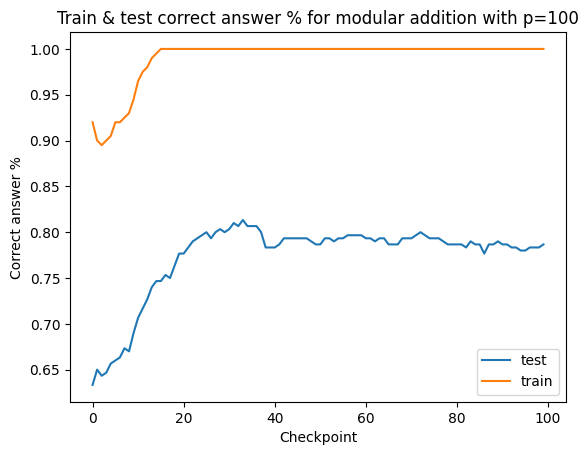

In [6]:
plt.plot(df["val_acc"], label="test")
plt.plot(df["train_acc"], label="train")
plt.legend()
plt.ylabel("Correct answer %")
plt.xlabel("Checkpoint")
plt.title(f"Train & test correct answer % for modular addition with p={params.p}")

From this plot, we see the classic grokking behavior: although the train accuracy is perfect after a few iterations, it takes many more examples for the test accuracy to meaningfully improve. (Note that this is not the same statement as train loss being perfect, see below plot.)

Text(0.5, 1.0, 'Train & test loss for modular addition with p=100')

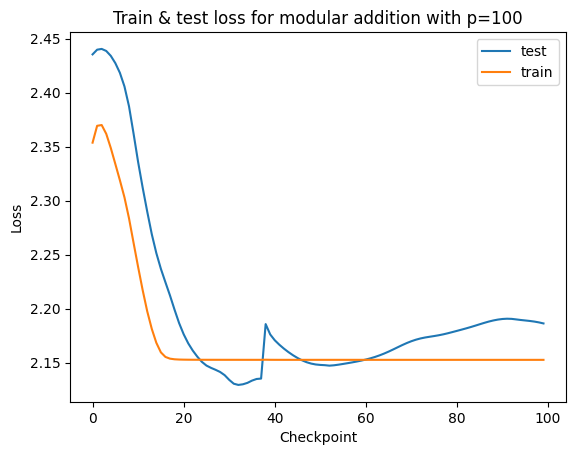

In [7]:
plt.plot(df["val_loss"], label="test")
plt.plot(df["train_loss"], label="train")
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Checkpoint")
plt.title(f"Train & test loss for modular addition with p={params.p}")

## LLC estimation hyperparameter tuning

In order to get LLC estimates for this simple grokking model over training, we first need to choose hyperparameters. The most important ones to calibrate are epsilon (the SGLD learning rate / step size) and n\*beta (the effective inverse temperature). Let's run a quick sweep over a wide range of epsilon and n\*beta, and look for a range of values within this which shows little change in LLC change in LLC values when we change epsilon and nbeta. We can use `devinterp.vis_utils.EpsilonBetaAnalyzer` for this.

In [8]:
import typing
from typing import Type

import numpy as np


def estimate_llc_given_model(
    model: torch.nn.Module,
    loader: torch.utils.data.DataLoader,
    evaluate: typing.Callable,
    epsilon: float,
    beta: float,
    sampling_method: Type[torch.optim.Optimizer] = SGLD,
    localization: float = 5.0,
    num_chains: int = 2,
    num_draws: int = 500,
    num_burnin_steps: int = 0,
    num_steps_bw_draws: int = 1,
    device: torch.device = DEVICE,
    online: bool = True,
    verbose: bool = False,
):
    sweep_stats = estimate_learning_coeff_with_summary(
        model,
        loader=loader,
        evaluate=evaluate,
        sampling_method=sampling_method,
        optimizer_kwargs=dict(lr=epsilon, localization=localization, nbeta=beta),
        num_chains=num_chains,  # How many independent chains to run
        num_draws=num_draws,  # How many samples to draw per chain
        num_burnin_steps=num_burnin_steps,  # How many samples to discard at the beginning of each chain
        num_steps_bw_draws=num_steps_bw_draws,  # How many steps to take between each sample
        device=device,
        online=online,
        verbose=verbose,
    )

    sweep_stats["llc/trace"] = np.array(sweep_stats["llc/trace"])
    return sweep_stats

In [ ]:
from devinterp.vis_utils import EpsilonBetaAnalyzer

loader = DataLoader(train_data, shuffle=True, batch_size=params.batch_size)
analyzer = EpsilonBetaAnalyzer()
analyzer.configure_sweep(
    llc_estimator=estimate_llc_given_model,
    llc_estimator_kwargs=dict(
        model=all_checkpointed_models[-1],
        evaluate=evaluate_ce,
        device=DEVICE,
        loader=loader,
    ),
    min_epsilon=3e-5,
    max_epsilon=3e-1,
    epsilon_samples=5,
    min_beta=None,
    max_beta=None,
    beta_samples=5,
    dataloader=loader,
)
analyzer.sweep()

In [ ]:
analyzer.plot()

From this, we can see that the final LLC flattens out if epsilon > 0.001, so that's the epsilon parameter range we should go for. But we also have some dependence of the llc on beta, which is maybe linear from the looks of it? We get our LLC estimates by taking (sampled_loss - initial_loss) * nbeta, so maybe that final nbeta term is what we're seeing here. Let's divide it out to see this better.

(Note that this does not quite mean the LLC curve should be fully linear in nbeta, as the choice of nbeta can and does influence the SGLD sampling process and so can change the sampled loss.)

In [ ]:
analyzer.plot(div_out_beta=True)

From this, we can see that the effective sampled loss for low-ish nbetas (<100) shows very little dependence on the exact choice of nbeta. So let's a point in this flat region (~1), and a high-but-still-in-the-flat-region epsilon (0.03), so we don't need to run many draws, but still have little dependence of our samples on epsilon.

Let's check that the loss chain for these hyperparams looks decent, and then run LLC estimation on all trained checkpoints if it does.

In [10]:
lr = 3e-3
gamma = 5
nbeta = 2.0
num_draws = 150
num_chains = 2

In [ ]:
learning_coeff_stats = estimate_learning_coeff_with_summary(
    all_checkpointed_models[-1],
    loader=DataLoader(train_data, batch_size=params.batch_size, shuffle=True),
    evaluate=evaluate_ce,
    sampling_method=SGLD,
    optimizer_kwargs=dict(lr=0.03, nbeta=2.0, localization=5.0),
    num_chains=3,
    num_draws=1500,
    device=DEVICE,
    online=True,
)
trace = learning_coeff_stats["loss/trace"]

In [ ]:
from devinterp.utils import plot_trace

plot_trace(
    trace,
    "Loss",
    x_axis="Step",
    title=f"Loss Trace, avg LLC = {sum(learning_coeff_stats['llc/means']) / len(learning_coeff_stats['llc/means']):.2f}",
    plot_mean=False,
    plot_std=False,
    fig_size=(12, 9),
    true_lc=None,
)

This looks good! The loss flattens out nicely, and well within the num_draws we chose. Looks like we can get away with using 500 draws, as the loss trace has well flattened out by then.

In [11]:
llcs = [
    estimate_learning_coeff_with_summary(
        model_checkpoint,
        loader=DataLoader(train_data, batch_size=params.batch_size, shuffle=True),
        evaluate=evaluate_ce,
        sampling_method=SGLD,
        optimizer_kwargs=dict(lr=lr, nbeta=nbeta, localization=gamma),
        num_chains=1,
        num_draws=num_draws,
        device=DEVICE,
        online=False,
    )
    for model_checkpoint in all_checkpointed_models
]

/home/wisp/anaconda3/envs/llc/lib/python3.10/site-packages/devinterp/slt/sampler.py:117: UserWarning: Using passed in nbeta. Make sure callbacks are also initialized with the same nbeta.
  warnings.warn(
/home/wisp/anaconda3/envs/llc/lib/python3.10/site-packages/devinterp/backends/default/slt/sampler.py:240: UserWarning: You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.
  warnings.warn(
/home/wisp/anaconda3/envs/llc/lib/python3.10/site-packages/devinterp/backends/default/slt/sampler.py:244: UserWarning: You are taking more sample batches than there are dataloader batches available, this removes some randomness from sampling but is probably fine. (All sample batches beyond the number dataloader batches are cycled from the start, f.e. 9 samples from [A, B, C] would be [B, A, C, B, A, C, B, A, C].)
  warnings.warn(
/home/wisp/anaconda3/envs/llc/lib/python3.10/site-packages/devinterp/backends/default/slt/samp

In [14]:
def calc_run_avg(arr, d):
    run_avgs = [None for _ in range(d // 2)]

    for i in range(len(arr) - d):
        avg = sum(arr[i:i + d]) / d
        run_avgs.append(avg)
    
    return run_avgs

In [29]:
def calc_delta(arr, scale):
    deltas = [None]

    for i in range(1, len(arr)):
        deltas.append((arr[i] - arr[i - 1]) * scale)
    
    return deltas

/tmp/ipykernel_18739/2941072590.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


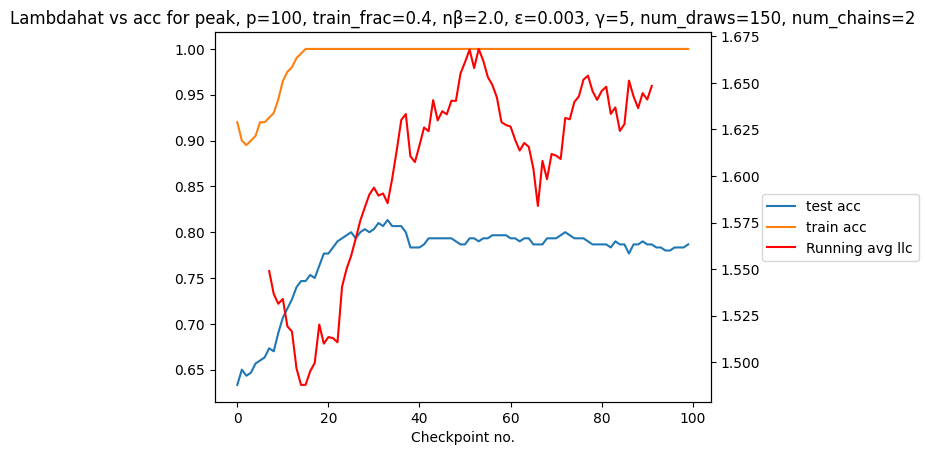

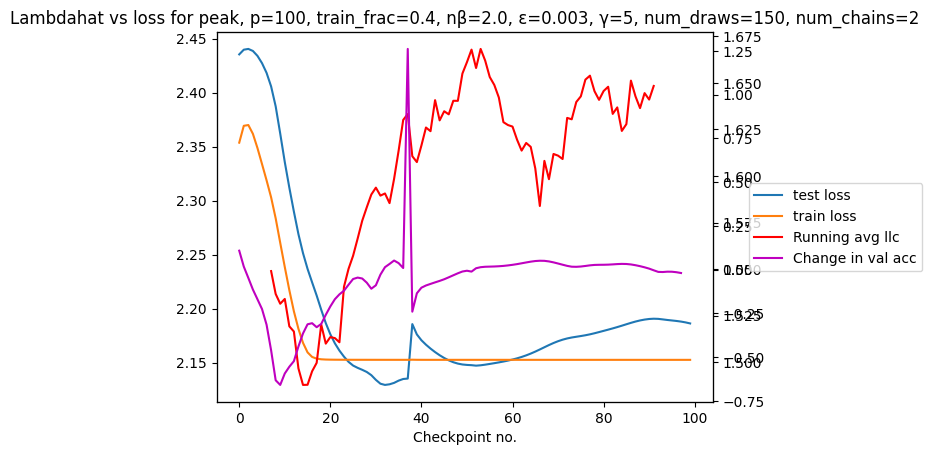

In [39]:
fig, ax1 = plt.subplots()
plt.title(
    f"Lambdahat vs acc for peak, p={params.p}, train_frac={params.train_frac}, nβ={nbeta:.1f}, ε={lr}, γ={gamma}, num_draws={num_draws}, num_chains={num_chains}"
)

run_avg_llc = calc_run_avg([llc["llc/mean"] for llc in llcs], 15)
delta_val_loss = calc_delta(df["val_loss"], 25)

ax2 = ax1.twinx()
ax1.plot(df["val_acc"], label="test acc")
ax1.plot(df["train_acc"], label="train acc")
# ax2.plot([llc["llc/mean"] for llc in llcs], color="g", label="Lambdahat")
ax2.plot(run_avg_llc, color="r", label="Running avg llc")
ax1.set_xlabel("Checkpoint no.")
fig.legend(loc="center right")

fig.show()

fig, ax1 = plt.subplots()
plt.title(
    f"Lambdahat vs loss for peak, p={params.p}, train_frac={params.train_frac}, nβ={nbeta:.1f}, ε={lr}, γ={gamma}, num_draws={num_draws}, num_chains={num_chains}"
)
ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax1.plot(df["val_loss"], label="test loss")
ax1.plot(df["train_loss"], label="train loss")
ax3.plot(calc_run_avg(delta_val_loss[1:], 1), color="m", label="Change in val acc")
# ax2.plot([llc["llc/mean"] for llc in llcs], color="g", label="Lambdahat")
ax2.plot(run_avg_llc, color="r", label="Running avg llc")
ax1.set_xlabel("Checkpoint no.")
fig.legend(loc="center right")